In [25]:
import numpy as np
import pandas as pd
import os

In [10]:
stores = pd.read_csv('data/stores.csv')
oil = pd.read_csv('data/oil.csv', parse_dates=['date'])
holidays = pd.read_csv('data/holidays_events.csv', parse_dates=['date'])
transactions = pd.read_csv('data/transactions.csv', parse_dates=['date'])

In [36]:
stores.info()
stores.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB


,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [35]:
oil.info()
oil.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        1218 non-null   datetime64[ns]
 1   dcoilwtico  1175 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 19.2 KB


,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [37]:
holidays.info()
holidays.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         350 non-null    datetime64[ns]
 1   type         350 non-null    object        
 2   locale       350 non-null    object        
 3   locale_name  350 non-null    object        
 4   description  350 non-null    object        
 5   transferred  350 non-null    bool          
dtypes: bool(1), datetime64[ns](1), object(4)
memory usage: 14.1+ KB


,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [38]:
transactions.info()
transactions.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          83488 non-null  datetime64[ns]
 1   store_nbr     83488 non-null  int64         
 2   transactions  83488 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.9 MB


,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [11]:
df_test = pd.read_csv('data/test.csv', parse_dates=['date'])

In [53]:
df_train = pd.read_csv('data/train.csv', parse_dates=['date'])
df_train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [39]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3000888 entries, 0 to 3000887
Data columns (total 10 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
 6   city         object        
 7   state        object        
 8   type         object        
 9   cluster      int64         
dtypes: datetime64[ns](1), float64(1), int64(4), object(4)
memory usage: 251.8+ MB


In [13]:
df_train.describe()

,id,store_nbr,sales,onpromotion
count,3.000888e+06,3.000888e+06,3.000888e+06,3.000888e+06
mean,1.500444e+06,2.750000e+01,3.577757e+02,2.602770e+00
std,8.662819e+05,1.558579e+01,1.101998e+03,1.221888e+01
min,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
25%,7.502218e+05,1.400000e+01,0.000000e+00,0.000000e+00
50%,1.500444e+06,2.750000e+01,1.100000e+01,0.000000e+00
75%,2.250665e+06,4.100000e+01,1.958473e+02,0.000000e+00
max,3.000887e+06,5.400000e+01,1.247170e+05,7.410000e+02


In [14]:
df_train.isna().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

In [15]:
df_train.nunique()

id             3000888
date              1684
store_nbr           54
family              33
sales           379610
onpromotion        362
dtype: int64

In [9]:
df_train = df_train.sort_values(by=['store_nbr', 'family', 'date'])

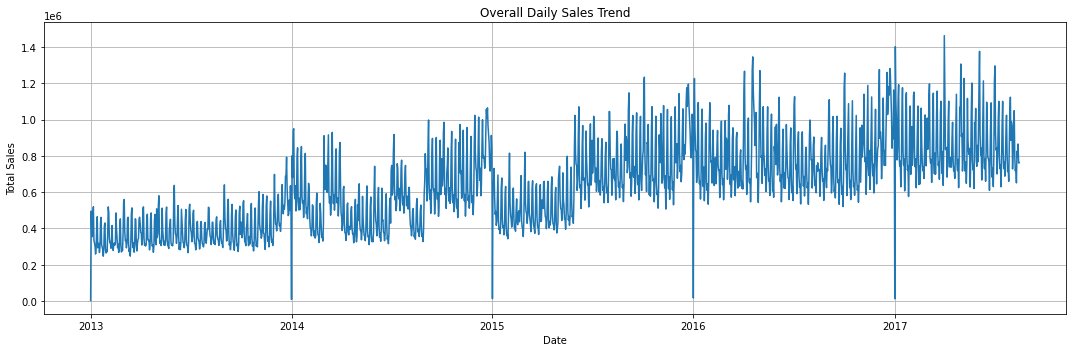

In [17]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Aggregate daily total sales across all stores and families
daily_sales = df_train.groupby('date')['sales'].sum()

# Plot the overall sales trend
plt.figure(figsize=(15, 5))
plt.plot(daily_sales.index, daily_sales.values)
plt.title('Overall Daily Sales Trend')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.grid(True)
plt.tight_layout()
plt.show()

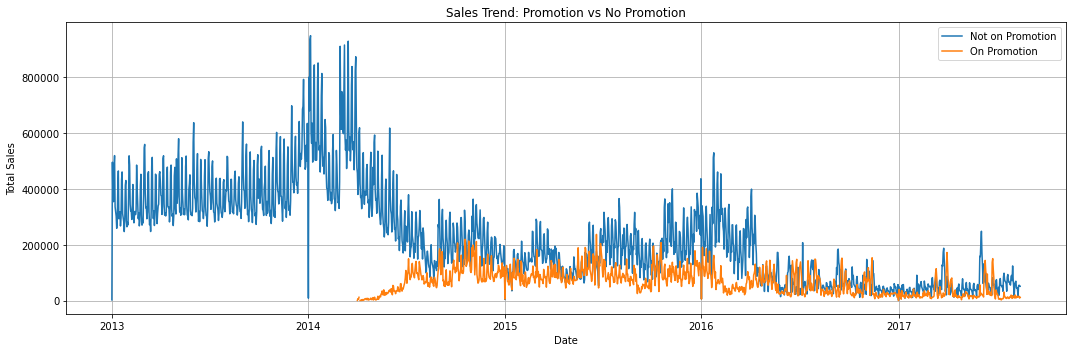

In [18]:
# Group by date and promotion status, then calculate total sales
promo_impact = df_train.groupby(['date', 'onpromotion'])['sales'].sum().unstack()

# Plot sales for promoted vs. non-promoted items
plt.figure(figsize=(15, 5))
plt.plot(promo_impact.index, promo_impact[0], label='Not on Promotion')
plt.plot(promo_impact.index, promo_impact[1], label='On Promotion')
plt.title('Sales Trend: Promotion vs No Promotion')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [40]:
stores.rename(columns={'type': 'store_type'}, inplace=True)
holidays.rename(columns={'type': 'holiday_type'}, inplace=True)

In [42]:
stores.head()

,store_nbr,city,state,store_type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [ ]:
# Add store type to the training data
df_train = df_train.merge(stores, on='store_nbr', how='left', suffixes=('', '_drop'))
df_train.head()

In [57]:
# Add oil prices to the training data
df_train = df_train.merge(oil, on='date', how='left', suffixes=('', '_drop'))
df_train.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,store_type,cluster,dcoilwtico
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,NaN
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,NaN
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,NaN
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,NaN
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,NaN


In [56]:
# Remove transferred holidays
holidays = holidays[holidays['transferred'] == False]

# Keep only valid holidays (not work days)
valid_types = ['Holiday', 'Additional', 'Bridge', 'Transfer']
holidays = holidays[holidays['holiday_type'].isin(valid_types)]

# Create three separate DataFrames for merging by locale
hol_national = holidays[holidays['locale'] == 'National'][['date', 'description']]
hol_national['is_holiday'] = True

hol_regional = holidays[holidays['locale'] == 'Regional'][['date', 'locale_name', 'description']]
hol_regional['is_holiday'] = True

hol_local = holidays[holidays['locale'] == 'Local'][['date', 'locale_name', 'description']]
hol_local['is_holiday'] = True

In [59]:
# Start with national holidays
df_train = df_train.merge(hol_national, on='date', how='left')

# Then merge regional (match on state)
df_train = df_train.merge(
    hol_regional, left_on=['date', 'state'], right_on=['date', 'locale_name'], how='left', suffixes=('', '_regional')
)

# Then merge local (match on city)
df_train = df_train.merge(
    hol_local, left_on=['date', 'city'], right_on=['date', 'locale_name'], how='left', suffixes=('', '_local')
)

df_train.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,store_type,cluster,dcoilwtico,description,is_holiday,locale_name,description_regional,is_holiday_regional,locale_name_local,description_local,is_holiday_local
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,NaN,Primer dia del ano,True,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,NaN,Primer dia del ano,True,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,NaN,Primer dia del ano,True,NaN,NaN,NaN,NaN,NaN,NaN
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,NaN,Primer dia del ano,True,NaN,NaN,NaN,NaN,NaN,NaN
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,NaN,Primer dia del ano,True,NaN,NaN,NaN,NaN,NaN,NaN


In [60]:
# Create a single is_holiday flag: True if any of the merges matched
df_train['is_holiday'] = (
    df_train['is_holiday'].fillna(False) |
    df_train['is_holiday_regional'].fillna(False) |
    df_train['is_holiday_local'].fillna(False)
)

# Drop temporary columns
df_train.drop(columns=['description', 'description_regional', 'description_local',
                           'is_holiday_regional', 'is_holiday_local',
                           'locale_name', 'locale_name_local'], errors='ignore', inplace=True)


In [61]:
df_train.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,store_type,cluster,dcoilwtico,is_holiday
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,NaN,True
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,NaN,True
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,NaN,True
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,NaN,True
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,NaN,True


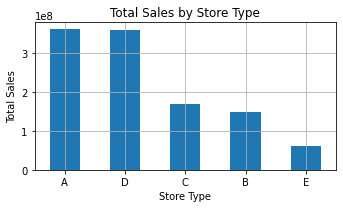

In [48]:
# Total sales by store type
sales_by_type = df_train.groupby('store_type')['sales'].sum().sort_values(ascending=False)

plt.figure(figsize=(5, 3))
sales_by_type.plot(kind='bar')
plt.title('Total Sales by Store Type')
plt.xlabel('Store Type')
plt.ylabel('Total Sales')
plt.xticks(rotation=0)
plt.tight_layout()
plt.grid(True)
plt.show()


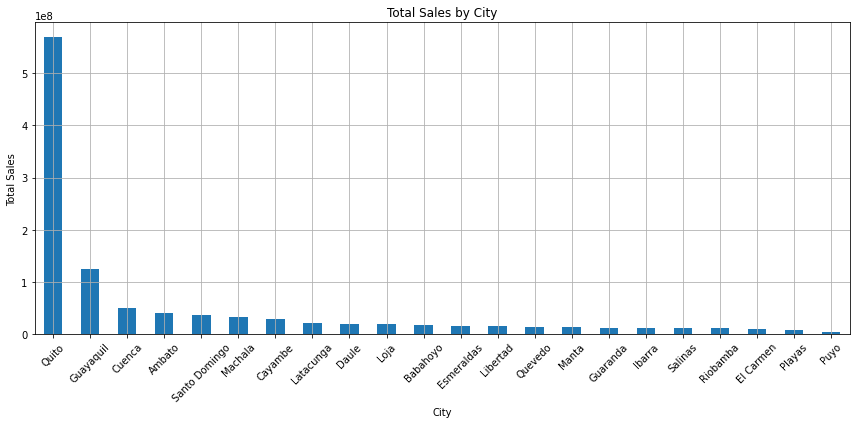

In [49]:
# Total sales by city
sales_by_city = df_train.groupby('city')['sales'].sum().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sales_by_city.plot(kind='bar')
plt.title('Total Sales by City')
plt.xlabel('City')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()

In [62]:
df_train.isnull().sum()

id                  0
date                0
store_nbr           0
family              0
sales               0
onpromotion         0
city                0
state               0
store_type          0
cluster             0
dcoilwtico     928686
is_holiday          0
dtype: int64